# PG

在梯度策略方法（Policy Gradient, 简称 PG）中，策略 $\pi_\theta(a|s)$ 由一个参数化模型表示（例如神经网络），其中 $\theta$ 是模型的参数。目标是通过调整 $\theta$，使得智能体在环境中的期望回报最大化。

### 目标函数

目标函数 $J(\theta)$ 通常表示为期望回报的期望值（以初始状态分布为起点），目标是找到参数 $\theta^*$，使得 $J(\theta)$ 最大化。：
$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ R(\tau) \right]
$$

- $R(\tau)$ 表示轨迹τ的总奖励。

$$
R(\tau) = \sum_{t=0}^{T} \gamma^t r_t,
$$

- $\tau = (s_0, a_0, s_1, a_1, \dots)$ 表示一个完整的轨迹。
- $r_t$ 是时间步 $t$ 的奖励。
- $\gamma \in [0, 1]$ 是折扣因子，用于平衡短期和长期回报。

由于轨迹的分布依赖于策略 $\pi_\theta$，轨迹分布可以写为：

$$
p_\theta(\tau) = p(s_0) \prod_{t=0}^{T} \pi_\theta(a_t | s_t) P(s_{t+1} | s_t, a_t),
$$

其中 $p(s_0)$ 是初始状态分布，$P(s_{t+1} | s_t, a_t)$ 是环境的状态转移概率。

### 梯度公式

为了最大化 $J(\theta)$，需要计算其梯度 $\nabla_\theta J(\theta)$，

$$
\nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta} [R(\tau)].
$$

利用期望的梯度公式，可以将梯度写成：

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \nabla_\theta \log p_\theta(\tau) \cdot R(\tau) \right],
$$

其中 $\nabla_\theta \log p_\theta(\tau)$ 是轨迹分布 $p_\theta(\tau)$ 的对数梯度。

> 期望的梯度公式是一个重要的数学工具，用于将期望的梯度转换为期望内的梯度。其形式为：
> 
> $$
> \nabla_\theta \mathbb{E}_{x \sim p_\theta(x)} [f(x)] = \mathbb{E}_{x \sim p_\theta(x)} \left[ f(x) \nabla_\theta \log p_\theta(x) \right],
> $$
> 
> 其中：
> 
> - **$p_\theta(x)$** 是由参数 **$\theta$** 控制的概率分布。
> - **$f(x)$** 是关于随机变量 **$x$** 的某个函数。
> - **$\nabla_\theta$** 表示对参数 **$\theta$** 的梯度。


### 对数似然求导

轨迹的概率分布 $p_\theta(\tau)$ 可以分解为：

$$
p_\theta(\tau) = p(s_0) \prod_{t=0}^{T} \pi_\theta(a_t | s_t) P(s_{t+1} | s_t, a_t).
$$

取对数：

$$
\log p_\theta(\tau) = \log p(s_0) + \sum_{t=0}^{T} \log \pi_\theta(a_t | s_t) + \sum_{t=0}^{T} \log P(s_{t+1} | s_t, a_t).
$$

由于初始状态分布 $p(s_0)$ 和状态转移概率 $P(s_{t+1} | s_t, a_t)$ 与参数 $\theta$ 无关（它们由环境决定），对 $\theta$ 求导时只剩下策略部分：

$$
\nabla_\theta \log p_\theta(\tau) = \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t | s_t).
$$

因此，梯度公式变为：

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ R(\tau) \cdot \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t | s_t) \right].
$$

### 简化公式

为了方便实现，通常将奖励分布 $R(\tau)$ 分解到每个时间步，并引入累计回报 $G_t$：

$$
G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k,
$$

表示从时间步 $t$ 开始的折扣累计回报。于是梯度公式可以写为：

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T G_t \cdot \nabla_\theta \log \pi_\theta(a_t | s_t) \right].
$$

在实现中，我们一般采用采样的方法（基于 Monte Carlo）来近似计算梯度。这需要：
- 采样多条轨迹 $\tau$。
- 计算每条轨迹的累计回报 $G_t$。
- 使用公式：
$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T} G_t^{(i)} \nabla_\theta \log \pi_\theta(a_t^{(i)} | s_t^{(i)}),
$$
其中 $N$ 是采样的轨迹数。

In [9]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 超参数
LEARNING_RATE = 0.01
GAMMA = 0.99  # 折扣因子
EPISODES = 1000  # 总训练回合
PRINT_INTERVAL = 50  # 打印结果的间隔

# 策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)  # 隐藏层
        self.fc2 = nn.Linear(128, action_dim)  # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# 采样轨迹
def collect_trajectory(env, policy_net):
    states, actions, rewards = [], [], []
    state, info = env.reset()
    done = False
    truncated = False

    while not done and not truncated:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = policy_net(state_tensor)  # 策略网络输出动作概率
        action = torch.multinomial(probs, num_samples=1).item()  # 按概率采样动作

        next_state, reward, done, truncated, _ = env.step(action)  # 与环境交互

        # 保存数据
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

# 计算累计回报
def compute_returns(rewards, gamma=GAMMA):
    returns = []
    G = 0
    for r in reversed(rewards):  # 从后往前计算
        G = r + gamma * G
        returns.insert(0, G)
    return returns


# 主训练
env = gym.make('CartPole-v1')  # 创建环境
state_dim = env.observation_space.shape[0]  # 状态空间维度
action_dim = env.action_space.n  # 动作空间维度

policy_net = PolicyNetwork(state_dim, action_dim)  # 初始化策略网络
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)  # 使用 Adam 优化器

for episode in range(EPISODES):
    # 采集一条轨迹
    states, actions, rewards = collect_trajectory(env, policy_net)

    # 计算累计回报
    returns = compute_returns(rewards, gamma=GAMMA)
    returns = torch.FloatTensor(returns)  # 转为张量
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # 标准化回报，提升稳定性

    # 计算策略梯度损失
    loss = 0
    for state, action, G in zip(states, actions, returns):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = policy_net(state_tensor)
        log_prob = torch.log(probs[0, action])  # 对应动作的对数概率， log \pi_\theta(a_t|s_t)
        loss += -log_prob * G  # REINFORCE 损失函数, sum(-G * log \pi_\theta(a_t|s_t))

    # 更新策略网络
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 打印训练信息
    if (episode + 1) % PRINT_INTERVAL == 0:
        print(f"Episode {episode + 1}/{EPISODES}, Total Reward: {sum(rewards)}")

env.close()


Episode 50/1000, Total Reward: 203.0
Episode 100/1000, Total Reward: 56.0
Episode 150/1000, Total Reward: 209.0
Episode 200/1000, Total Reward: 500.0
Episode 250/1000, Total Reward: 500.0
Episode 300/1000, Total Reward: 500.0
Episode 350/1000, Total Reward: 23.0
Episode 400/1000, Total Reward: 26.0
Episode 450/1000, Total Reward: 25.0
Episode 500/1000, Total Reward: 500.0
Episode 550/1000, Total Reward: 500.0
Episode 600/1000, Total Reward: 500.0
Episode 650/1000, Total Reward: 500.0
Episode 700/1000, Total Reward: 500.0
Episode 750/1000, Total Reward: 500.0
Episode 800/1000, Total Reward: 12.0
Episode 850/1000, Total Reward: 500.0
Episode 900/1000, Total Reward: 500.0
Episode 950/1000, Total Reward: 500.0
Episode 1000/1000, Total Reward: 500.0


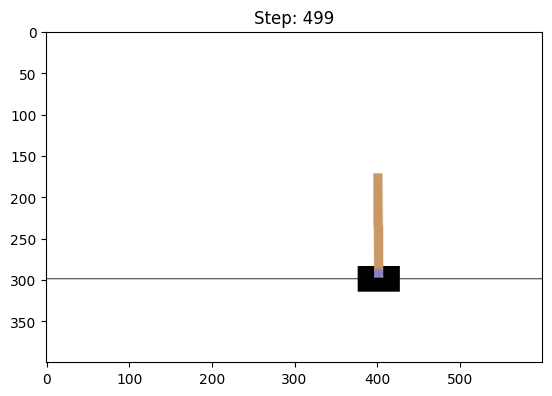

reached max steps
Total steps: 500


In [10]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

env = gym.make('CartPole-v1', render_mode='rgb_array')
state, info = env.reset()
done = False
truncated = False
step = 0
while not done and truncated == False:
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.show()
    prob = policy_net(torch.FloatTensor(state))
    action = torch.argmax(prob).item()
    state, reward, done, truncated, info = env.step(action)
    step += 1

    if step == 500:
        print("reached max steps")
env.close()

print(f"Total steps: {step}")

# TRPO

信赖域策略优化（Trust Region Policy Optimization, TRPO）

# PPO

近端策略优化（Proximal Policy Optimization，PPO）